<a href="https://colab.research.google.com/github/nantmoe-theingi/airbnb-nz-deception-sentiment/blob/main/notebooks/03_svm_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
PROJECT_DRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment"

from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs(PROJECT_DRIVE_DIR, exist_ok=True)
print("Drive project folder:", PROJECT_DRIVE_DIR)

Mounted at /content/drive
Drive project folder: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [2]:
cd {PROJECT_DRIVE_DIR}

/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [3]:
import pandas as pd
import numpy as np
import re

# Load the data
CSV = "data/tripadvisor_hotel_reviews.csv"
df = pd.read_csv(CSV)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
TEXT_COL = "Review"
RATING_COL = "Rating"

# === 2) Basic cleaning ===
def norm_ws(s: pd.Series) -> pd.Series:
    zws = r'[\u200B-\u200D\uFEFF]'
    s = s.astype(str).str.replace(zws, "", regex=True)
    return s.str.replace(r"\s+", " ", regex=True).str.strip()

df[TEXT_COL] = norm_ws(df[TEXT_COL])
df[RATING_COL] = pd.to_numeric(df[RATING_COL], errors="coerce")

# Drop rows with missing text or rating
before = len(df)
df = df.dropna(subset=[TEXT_COL, RATING_COL]).copy()
df = df.loc[df[TEXT_COL].str.len() > 0]
print(f"Removed {before - len(df):,} rows with missing/empty text or rating.")


Removed 0 rows with missing/empty text or rating.


In [5]:
# Remove exact duplicate texts
dup_texts = df.duplicated(subset=[TEXT_COL]).sum()
df = df.drop_duplicates(subset=[TEXT_COL]).copy()
print(f"Removed {dup_texts:,} duplicate review texts.")

# remove symbol-only reviews
import regex as re
def is_symbol_only(x: str) -> bool:
    return not bool(re.search(r"\p{L}", x, flags=re.UNICODE))
sym = df[TEXT_COL].apply(is_symbol_only).sum()
df = df.loc[~df[TEXT_COL].apply(is_symbol_only)].copy()
print(f"Removed {sym:,} symbol-only reviews.")

Removed 0 duplicate review texts.
Removed 0 symbol-only reviews.


In [6]:
# Map rating -> 3-class sentiment
def map_sentiment(star: float) -> str:
    if star <= 2:
        return "negative"
    elif star == 3:
        return "neutral"
    else:  # 4–5
        return "positive"

df["sentiment"] = df[RATING_COL].apply(map_sentiment)

# numeric y for models
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["y"] = df["sentiment"].map(label_map).astype(int)

In [7]:
# EDA
print("\nClass distribution:")
print(df["sentiment"].value_counts().sort_index())
print("\nClass distribution (%):")
print((df["sentiment"].value_counts(normalize=True)*100).round(2).sort_index())

df["length_words"] = df[TEXT_COL].str.split().apply(len)
print("\nLength (words): mean=", round(df["length_words"].mean(),2),
      "min=", df["length_words"].min(), "max=", df["length_words"].max())


Class distribution:
sentiment
negative     3214
neutral      2184
positive    15093
Name: count, dtype: int64

Class distribution (%):
sentiment
negative    15.68
neutral     10.66
positive    73.66
Name: proportion, dtype: float64

Length (words): mean= 104.38 min= 7 max= 1931


In [8]:
# Keep only that need for modeling and save cleaned file
out = df[[TEXT_COL, "sentiment", "y"]].rename(columns={TEXT_COL: "text"})
out.to_csv("data/tripadvisor_prepared_3class.csv", index=False)
print("\nSaved: tripadvisor_prepared_3class.csv")


Saved: tripadvisor_prepared_3class.csv


Counts:
 sentiment
negative     3214
neutral      2184
positive    15093
Name: count, dtype: int64

Percentages (%):
 sentiment
negative    15.68
neutral     10.66
positive    73.66
Name: count, dtype: float64


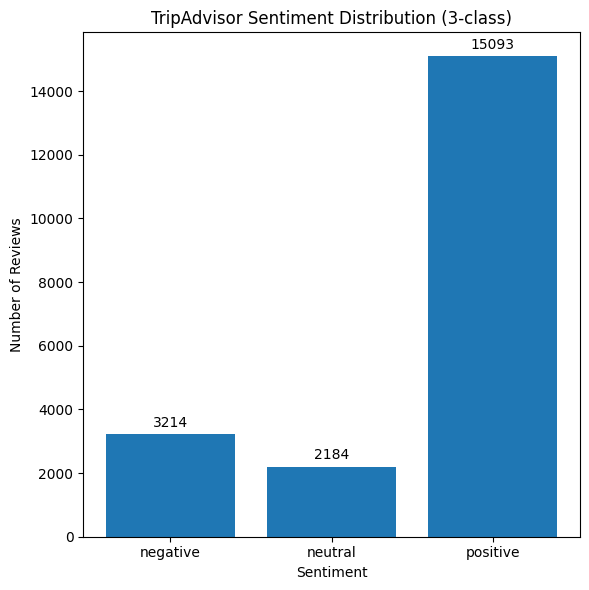

In [24]:
# plotting
order = ["negative", "neutral", "positive"]
counts = df["sentiment"].value_counts().reindex(order, fill_value=0)
pct = (counts / counts.sum() * 100).round(2)
print("Counts:\n", counts)
print("\nPercentages (%):\n", pct)

# Plot
plt.figure(figsize=(6,6))
bars = plt.bar(counts.index, counts.values)
plt.title("TripAdvisor Sentiment Distribution (3-class)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")

# Add labels
for b in bars:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y + max(counts.values)*0.01, f"{int(y)}", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("figures/figure3_3_tripadvisor_sentiment_distribution.png", dpi=300)
plt.show()

In [9]:
# 3-class sentiment: TF–IDF + LinearSVC
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import joblib
import matplotlib.pyplot as plt

In [10]:
RANDOM_STATE = 42
ARTIFACTS = Path("artifacts/sentiment_svm")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

In [11]:
# Load prepared file
df_cleaned = pd.read_csv("data/tripadvisor_prepared_3class.csv")

LABEL_COL = "y"
TEXT_COL  = "text"

In [12]:
RANDOM_SEED = 42
train_df, test_df = train_test_split(
    df_cleaned[[TEXT_COL, LABEL_COL]], test_size=0.15, random_state=RANDOM_SEED,
    stratify=df[LABEL_COL]
)
train_df, val_df = train_test_split(
    train_df, test_size=0.1765, random_state=RANDOM_SEED,  # ~15% of total
    stratify=train_df[LABEL_COL]
)

In [13]:
print(f"Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

Train=14342, Val=3075, Test=3074


In [14]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
classes = np.array(sorted(train_df[LABEL_COL].unique()))
class_weights = compute_class_weight("balanced", classes=classes, y=train_df[LABEL_COL])
class_weights = {int(c):float(w) for c,w in zip(classes, class_weights)}
print(class_weights)

{0: 2.124740740740741, 1: 3.1287085514834208, 2: 0.4525432285750347}


In [16]:
label_names = {0:"negative", 1:"neutral", 2:"positive"}

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
import joblib

svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )),
   ("clf", LinearSVC(class_weight=class_weights))
])

param_grid = {
    "tfidf__min_df": [2, 5],
    "tfidf__max_df": [0.9, 0.95],
    "clf__C": [0.25, 0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
grid = GridSearchCV(
    svm_pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring="f1_macro"
)
grid.fit(train_df[TEXT_COL], train_df[LABEL_COL])

print("Best params:", grid.best_params_)
best_svm = grid.best_estimator_
pred_val = best_svm.predict(val_df[TEXT_COL])
print(classification_report(val_df[LABEL_COL], pred_val, target_names=[label_names[i] for i in sorted(label_names)]))

# test
best_svm.fit(pd.concat([train_df[TEXT_COL], val_df[TEXT_COL]]),
             pd.concat([train_df[LABEL_COL], val_df[LABEL_COL]]))
pred_test = best_svm.predict(test_df[TEXT_COL])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'clf__C': 0.5, 'tfidf__max_df': 0.9, 'tfidf__min_df': 5}
              precision    recall  f1-score   support

    negative       0.78      0.86      0.82       482
     neutral       0.50      0.27      0.35       328
    positive       0.92      0.96      0.94      2265

    accuracy                           0.87      3075
   macro avg       0.73      0.70      0.70      3075
weighted avg       0.85      0.87      0.86      3075



In [18]:
print("\nTest")
print("Accuracy:", accuracy_score(test_df[LABEL_COL], pred_test))
print("Macro-F1:", f1_score(test_df[LABEL_COL], pred_test, average="macro"))
print(classification_report(test_df[LABEL_COL], pred_test, target_names=["negative","neutral","positive"]))


Test
Accuracy: 0.8659726740403383
Macro-F1: 0.7029288522111433
              precision    recall  f1-score   support

    negative       0.78      0.83      0.80       482
     neutral       0.48      0.30      0.37       328
    positive       0.92      0.96      0.94      2264

    accuracy                           0.87      3074
   macro avg       0.73      0.69      0.70      3074
weighted avg       0.85      0.87      0.86      3074



In [19]:
cm = confusion_matrix(test_df[LABEL_COL], pred_test)
print("Confusion matrix (test):\n", cm)

Confusion matrix (test):
 [[ 399   46   37]
 [  73   98  157]
 [  38   61 2165]]


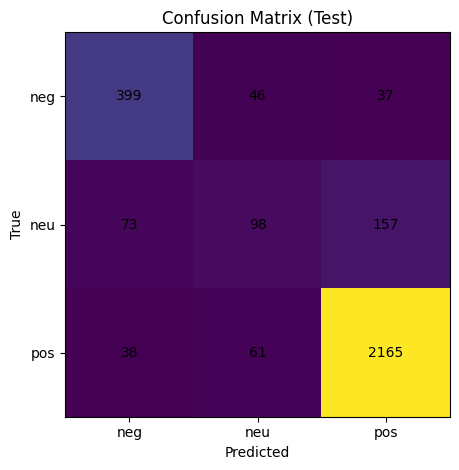

In [20]:
# confusion-matrix plot
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.xticks([0,1,2], ["neg","neu","pos"])
plt.yticks([0,1,2], ["neg","neu","pos"])
for (i,j),v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

In [22]:
# Save artifacts
joblib.dump(best_svm, ARTIFACTS / "svm_sentiment_pipeline.joblib")
joblib.dump({"negative":0, "neutral":1, "positive":2}, ARTIFACTS / "label_map.joblib")
print("Saved model + label map to:", ARTIFACTS.resolve())

Saved model + label map to: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment/artifacts/sentiment_svm


In [25]:
# Inference helper
def predict_sentiment(texts, model_path="artifacts/sentiment_svm/svm_sentiment_pipeline.joblib"):
    model = joblib.load(model_path)
    return model.predict(pd.Series(texts))  # returns numeric labels 0/1/2

In [26]:
texts = [
    "The place was amazing and the host was very friendly!",
    "It was okay, not great but not terrible either.",
    "Terrible experience — the room was dirty and noisy."
]

preds = predict_sentiment(texts)
print(preds)

[2 0 0]
